In [47]:
import cv2
import numpy as np
from skimage import morphology
from skimage.io import imread
from skimage.morphology import medial_axis, skeletonize
from scipy.ndimage import distance_transform_edt
import math
import copy
import tensorflow as tf
from PIL import Image
from scipy import signal
from torchvision.transforms import ToPILImage
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [48]:
data0 = cv2.imread('20.jpg')
data = data0[:,:,0]

平滑

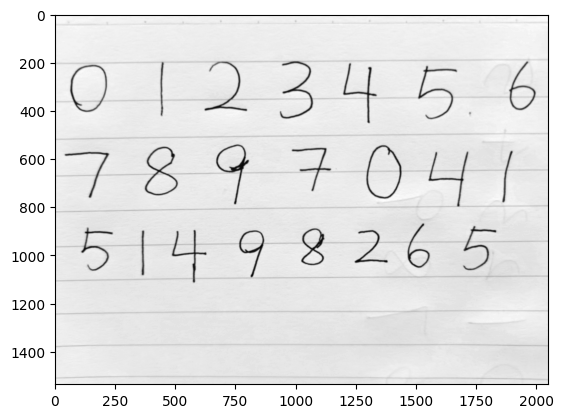

In [49]:
kernel_size = (4, 4)

# 应用平滑盒式滤波
smoothed_image = cv2.blur(data, kernel_size)
plt.imshow(smoothed_image, cmap='gray')

阈值

In [50]:
def threshold(data):
    data = np.real(data)
    max = np.max(data)
    min = np.min(data)
    thresh = (max)*3/5
    x, y = data.shape
    newData = np.zeros([x, y])
    for i in range(x):
        for j in range(y):
            if(data[i ,j] < thresh):
                newData[i ,j] = 1
    return newData

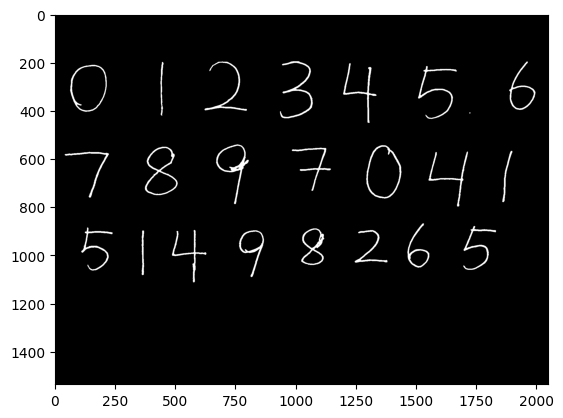

In [51]:
thresholdData = threshold(data)
plt.imshow(thresholdData, cmap='gray')

膨胀

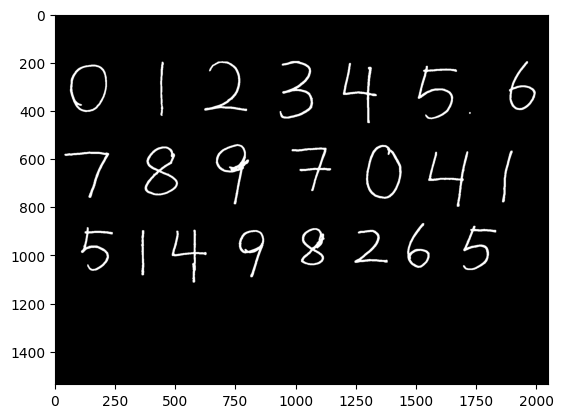

In [52]:
# Creating kernel
kernel = np.ones((3, 3), np.uint8)
    
# 膨胀
dilateData = cv2.dilate(thresholdData, kernel) 
plt.imshow(dilateData, cmap='gray')

骨骼化

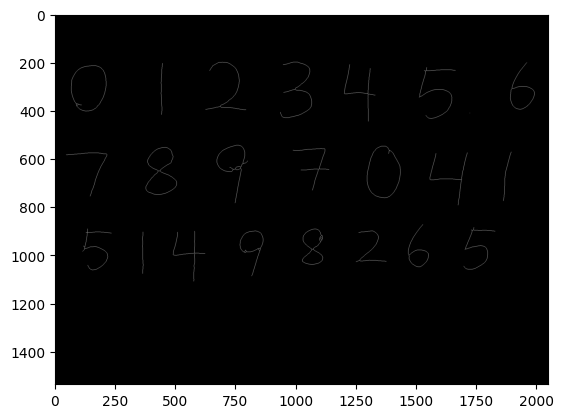

In [53]:
#骨骼化
skeleton0 = morphology.skeletonize(dilateData, method='lee')
skeleton = skeleton0.astype(np.uint8)*255
plt.imshow(skeleton,cmap='gray')

框选

In [54]:
def get_bounding_box(skeleton):
    # 查找骨架的轮廓
    skeleton = np.array(skeleton)

    # 膨胀,防止断开
    kernel = np.ones((6, 6), np.uint8)
    skeleton = cv2.dilate(skeleton, kernel) 

    contours, _ = cv2.findContours(skeleton, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 创建空白图像
    bounding_box = np.zeros_like(skeleton)
    i, j = bounding_box.shape
    flag = False
    bounds = []
    for contour in contours:
        # 计算骨架的边界框
        x, y, w, h = cv2.boundingRect(contour)
        # print(x+h/2,y+w/2)
        # if(abs(x+h/2-i/2)<300 and abs(y+w/2-j/2)<300 and w<200 and w>10 and h<200 and h>30):
        if(w<800 and w>5 and h<800 and h>30):
        # 绘制边界框
            cv2.rectangle(bounding_box, (x, y), (x + w, y + h), 255, -1)
            bounds.append([y, x, w, h])
            flag = True
    #返回全部框
    if(flag):
        print(bounds)
        return bounds, bounding_box
    else:    
        cv2.rectangle(bounding_box, (int(i/4), int(j/4)), (int(i/2), int(j/2)), 255, -1)
        bounds.append([int(i/4), int(j/4), int(i/2), int(j/2)])
        print(bounds)
        return bounds, bounding_box

def makeframe(skeleton, bounds):  
    print(skeleton.shape) 
    # temp = x
    # x = y
    # y = temp
    masks = []
    for bound in bounds:
        x, y, w, h = bound[0], bound[1], bound[2], bound[3]
        x = int(x + h/2 - max(h,w)/2-60)
        y = int(y + w/2 - max(h,w)/2-20)
        w = max(h, w)+40
        h = max(h, w)+70
        if(x<0):
            x=0
        if(y<0):
            y=0
        print('frame',x,y,w,h)

        maskSk = np.zeros([h, w])
        for i in range(h):
            for j in range(w):
                if(x+i<skeleton.shape[0] and y+j<skeleton.shape[1]):
                    maskSk[i, j] = skeleton[x + i, y + j]
        masks.append(maskSk)

    return masks

[[902, 361, 9, 179], [899, 488, 139, 214], [898, 1248, 132, 134], [898, 766, 102, 193], [890, 1025, 91, 153], [889, 112, 126, 177], [883, 1695, 137, 180], [871, 1465, 90, 182], [574, 44, 176, 186], [573, 1555, 161, 224], [570, 1860, 39, 209], [556, 986, 156, 179], [551, 375, 134, 202], [546, 1294, 145, 221], [542, 670, 134, 246], [219, 1510, 157, 218], [212, 65, 151, 195], [207, 1199, 135, 242], [202, 438, 12, 219], [199, 1889, 106, 200], [197, 934, 136, 237], [197, 623, 174, 204]]
(1536, 2048)
frame 842 256 219 289
frame 839 430 254 324
frame 838 1227 174 244
frame 838 700 233 303
frame 830 974 193 263
frame 829 66 217 287
frame 823 1653 220 290
frame 811 1399 222 292
frame 514 19 226 296
frame 513 1503 264 334
frame 510 1755 249 319
frame 496 954 219 289
frame 491 321 242 312
frame 486 1236 261 331
frame 482 594 286 356
frame 159 1459 258 328
frame 152 23 235 305
frame 147 1125 282 352
frame 142 314 259 329
frame 139 1822 240 310
frame 137 863 277 347
frame 137 588 244 314


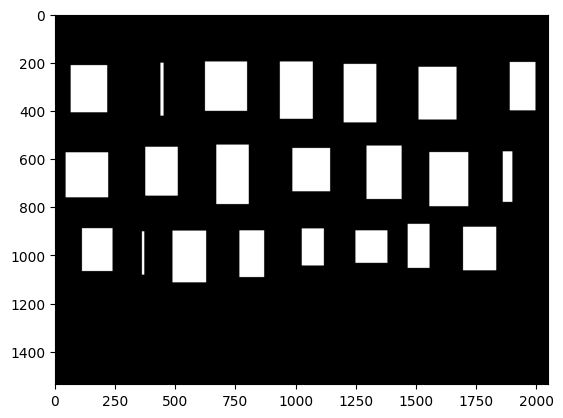

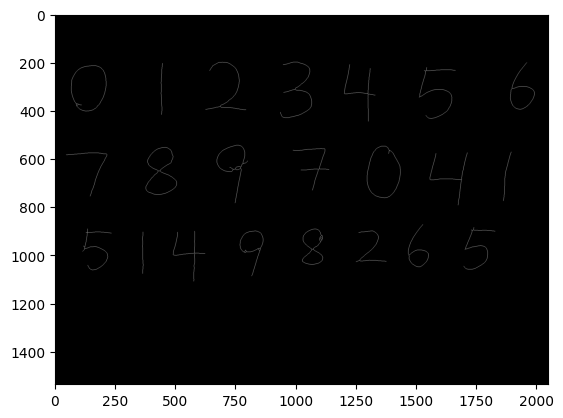

In [55]:
#框选
bounds, bounding_box= get_bounding_box(skeleton)

#masks
masks = makeframe(skeleton, bounds)
plt.imshow(bounding_box, cmap='gray')
plt.show()
plt.imshow(skeleton*bounding_box, cmap='gray')
plt.show()

In [56]:
# binary image
def binary(data):
    max = np.max(data)
    x, y = data.shape
    newData = np.zeros([x, y])
    for i in range(x):
        for j in range(y):
            if (data[i, j] > max/2):
                newData[i ,j] = 1
    return newData

# boundary tracing
def boundaryTracing(data):
    x, y = data.shape
    # make binary image
    binaryData = binary(data)
    start = [0, 0]

    # find start point
    flag = False
    for i in range(int(x/2)):
        for j in range(y):
            # print('2')
            if (binaryData[i+int(x/2), j] == 1):
                start[0] = i+int(x/2)
                start[1] = j
                flag = True
                # print('ok',start)
                break
        if(flag):
            break    
            
    b = [0, 0]
    b[0] = start[0]
    b[1] = start[1]
    
    c = [0, 0]
    c[0] = b[0]
    c[1] = b[1]
    if(b[1] == 0):
        c[0] = b[0] - 1
    else :   
        c[1] = b[1] - 1
    
    boundaryList = []
    boundaryList.append(start)
    print('start point:',start)
    # find chain
    cList = [[0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1], [1, 0], [1, 1]]
    number = 4
    c = cList[number]
    # print(start,b,c)

    chainCode = []

    # search for next point
    while b == start:
        if(binaryData[b[0]+c[0], b[1]+c[1]] == 1):# find
            b = [b[0]+c[0], b[1]+c[1]]
            boundaryList.append(b)
            chainCode.append(number)
            # print(number)
            # print(cList[number + 1][0] - cList[number][0])
            nextnum = number + 1
            if(number==7):
                nextnum = 0
            number = cList.index([cList[nextnum][0] - cList[number][0], cList[nextnum][1] - cList[number][1]])
            number -= 1
            if(number == -1):
                number = 7
        else:# next
            number -= 1
            if(number == -1):
                number = 7
        c = cList[number]

    # search until back to start
    while b != start:
        if(binaryData[b[0]+c[0], b[1]+c[1]] == 1):# find
            b = [b[0]+c[0], b[1]+c[1]]
            boundaryList.append(b)
            chainCode.append(number)
            numberbig = number+1
            if(numberbig == 8):
                numberbig = 0
            number = cList.index([cList[numberbig][0] - cList[number][0], cList[numberbig][1] - cList[number][1]])
            number -= 1
            if(number == -1):
                number = 7
        else:# next
            number -= 1
            if(number == -1):
                number = 7
        c = cList[number]

    print('boundary',boundaryList)
    print('chaincode',chainCode)
    boundaryImg = np.zeros([x, y])
    
    for boundary in boundaryList:
        boundaryImg[boundary[0], boundary[1]] = 1
    return boundaryImg, boundaryList, chainCode

In [57]:
# 剪枝
def cutoff(chain, boundaryList, step):
    leng = len(chain)
    for k in range(step):
        for i in range(leng):
            if(abs(chain[i]-chain[i-1])==4):
                chain[i] = 20
                chain[i-1] = 20
                boundaryList[i] = [0,0]
                boundaryList[i-1] = [0,0]
                
        while 20 in chain:
            chain.remove(20)
        leng = len(chain)
        while [0,0] in boundaryList:
            boundaryList.remove([0,0])
    newData = np.zeros([28, 28])
    for boundary in boundaryList:
        newData[boundary[0], boundary[1]] = 1

    return newData

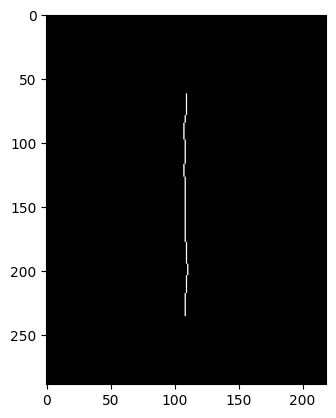

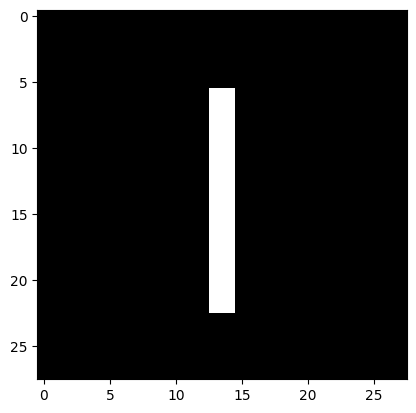

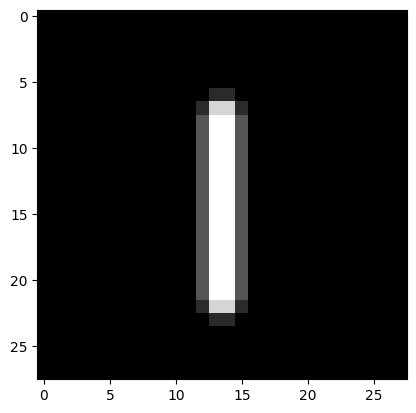

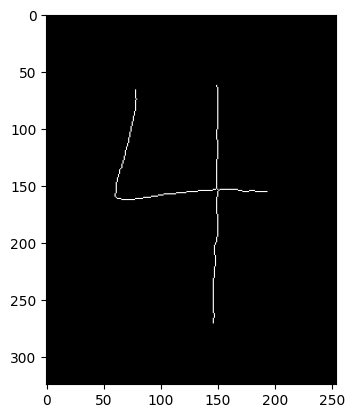

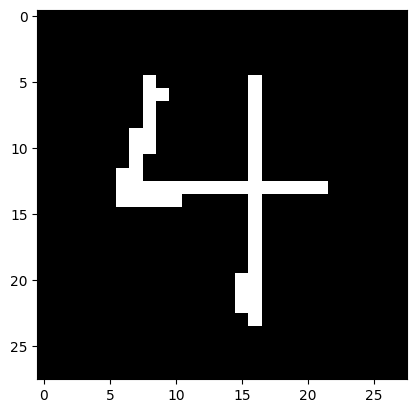

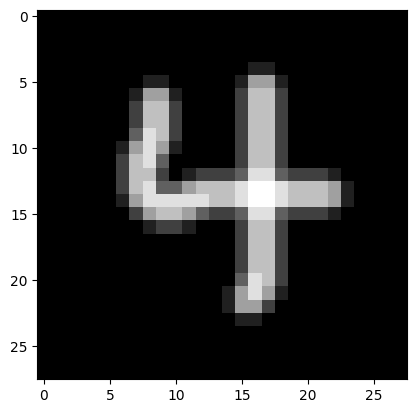

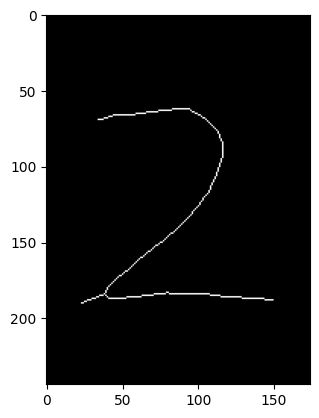

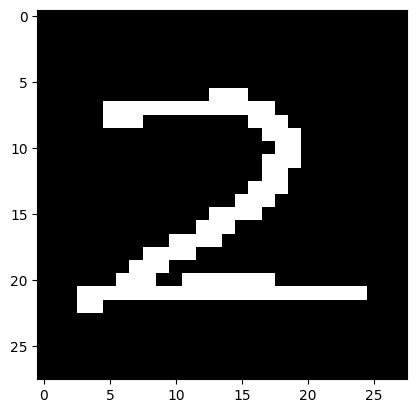

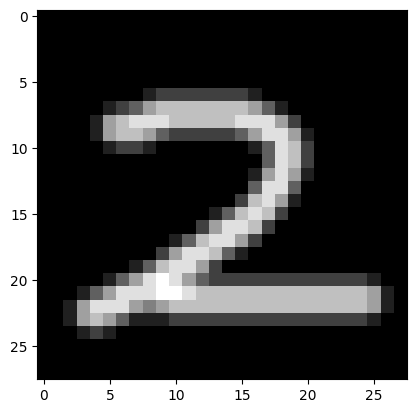

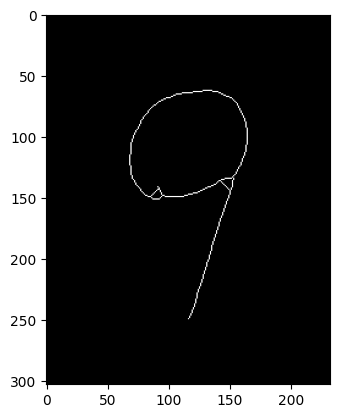

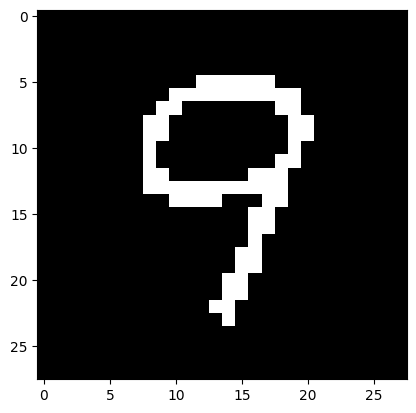

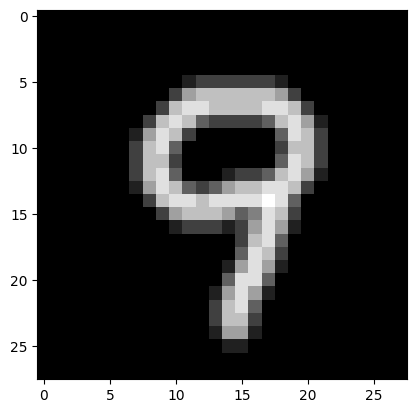

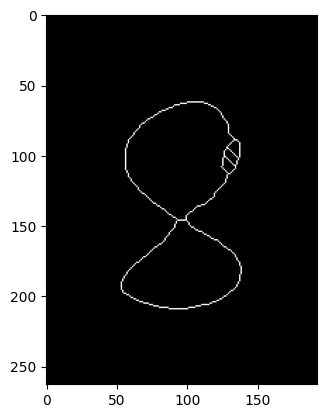

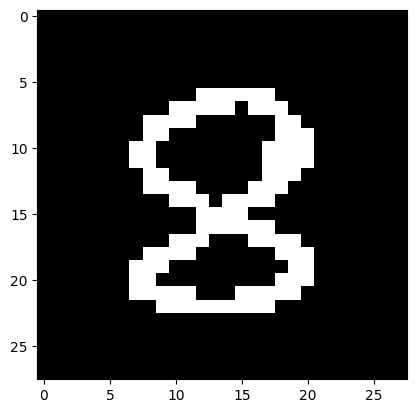

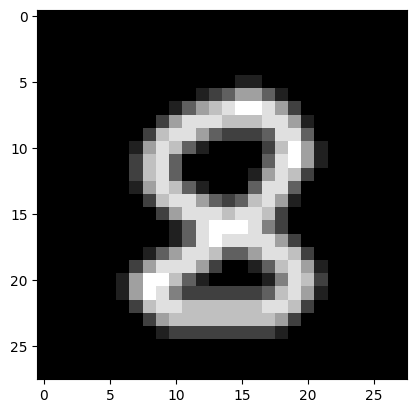

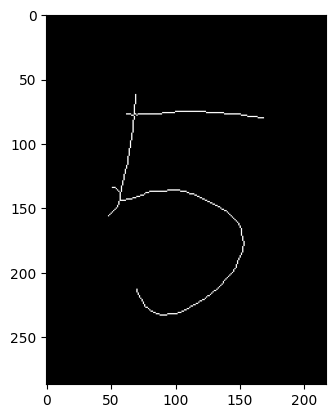

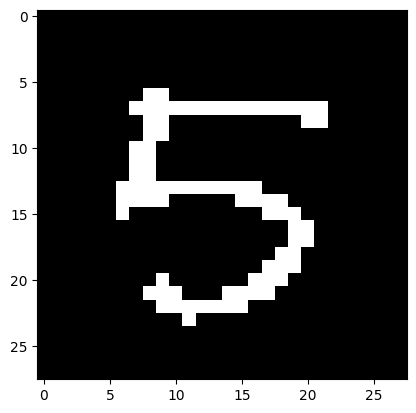

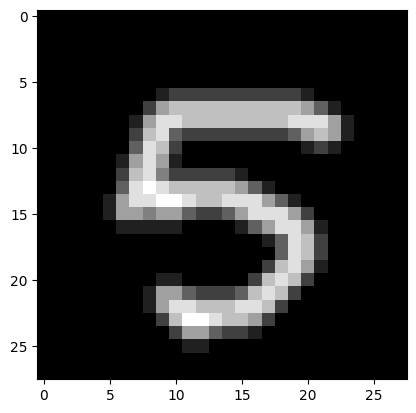

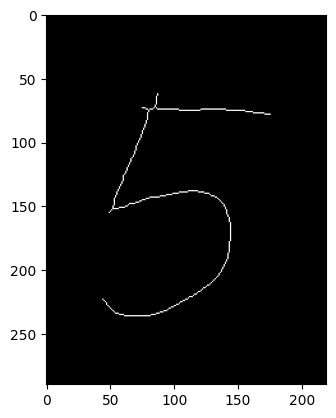

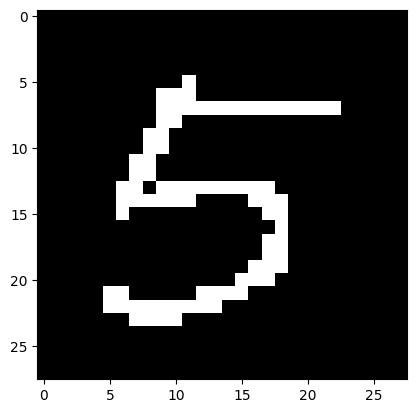

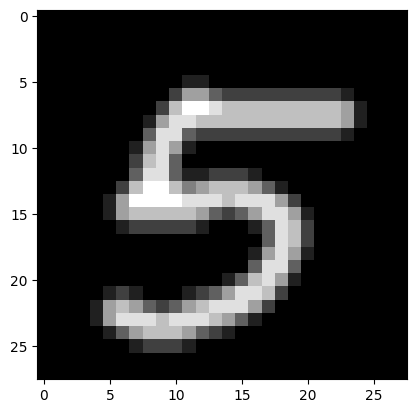

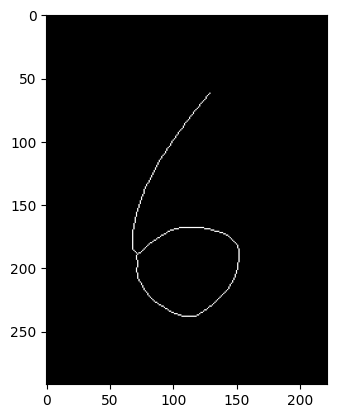

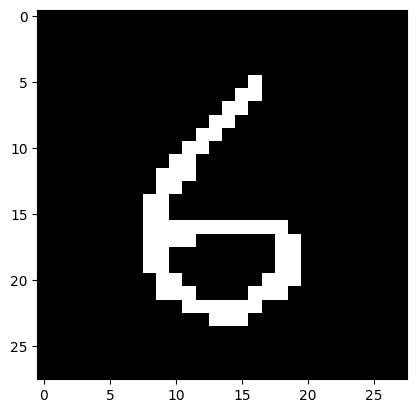

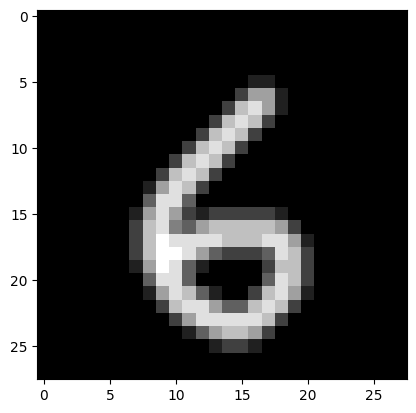

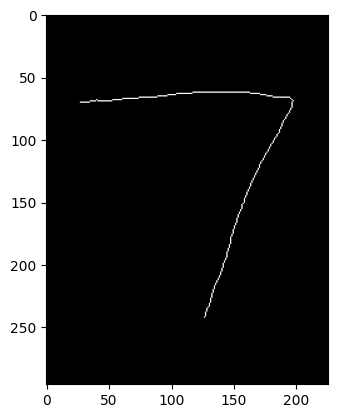

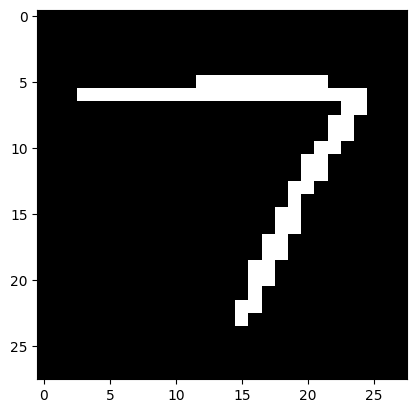

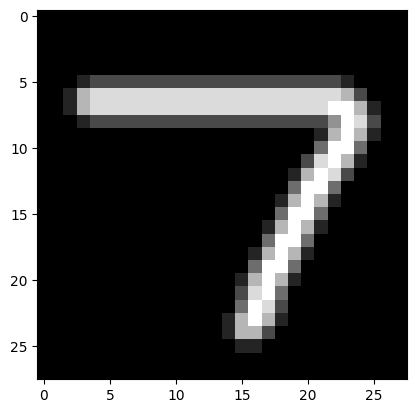

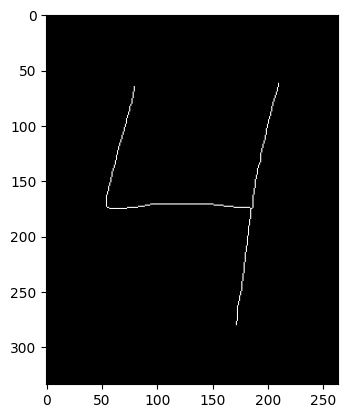

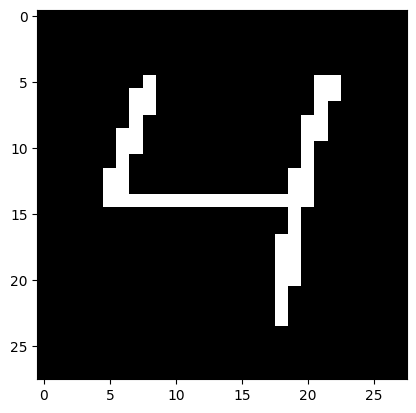

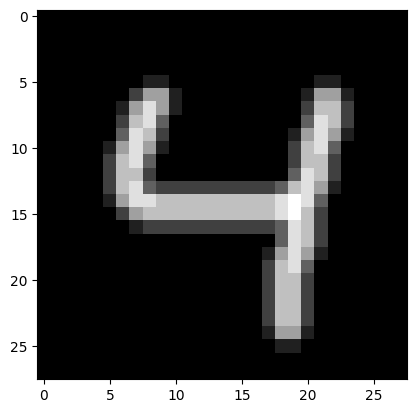

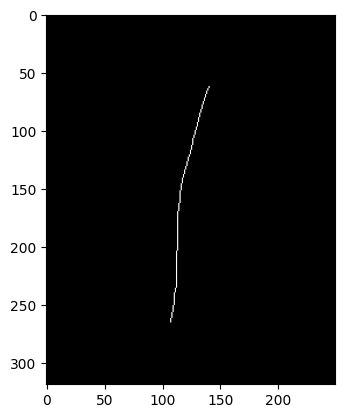

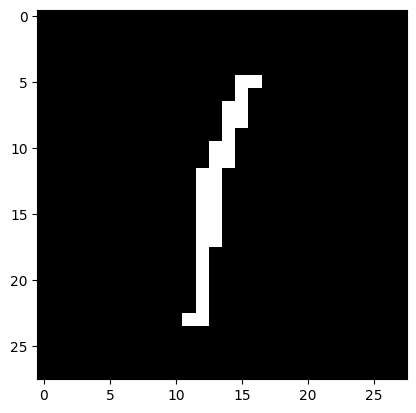

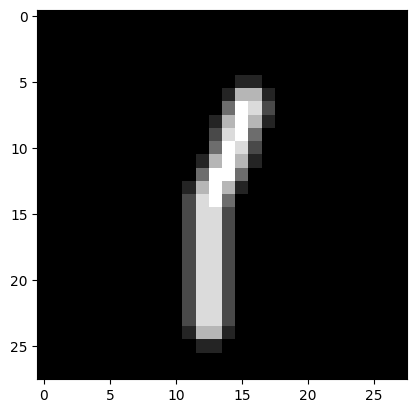

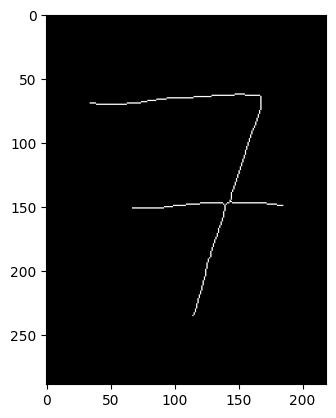

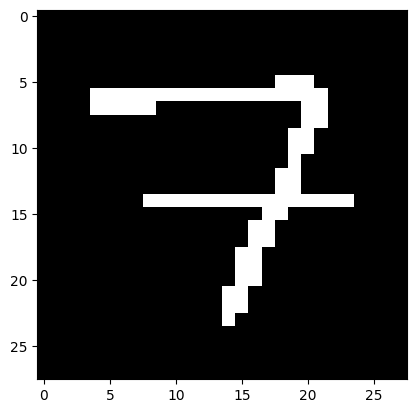

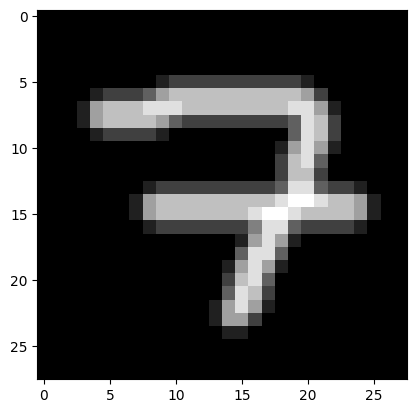

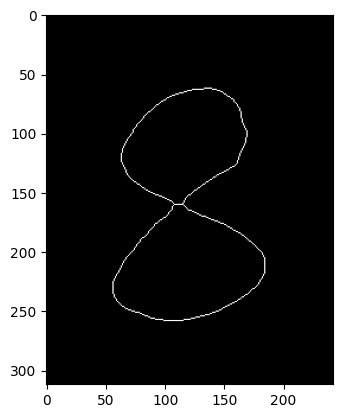

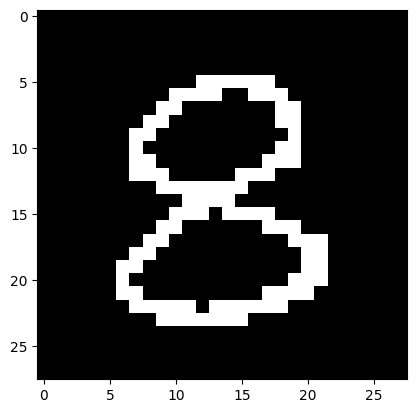

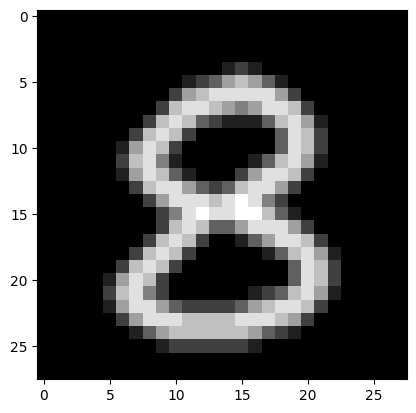

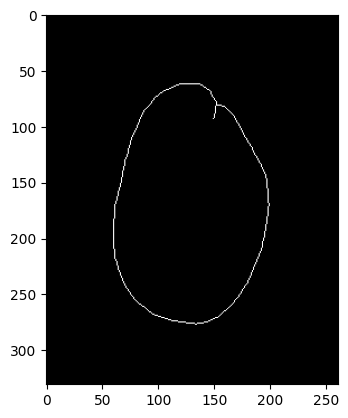

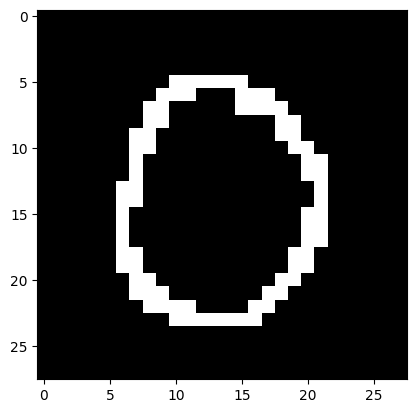

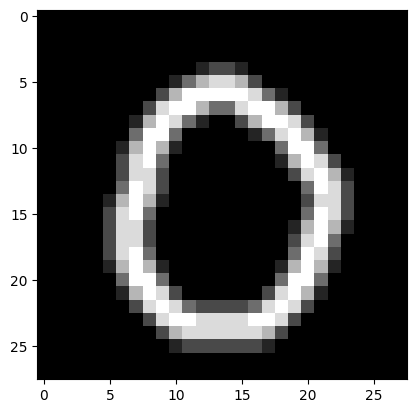

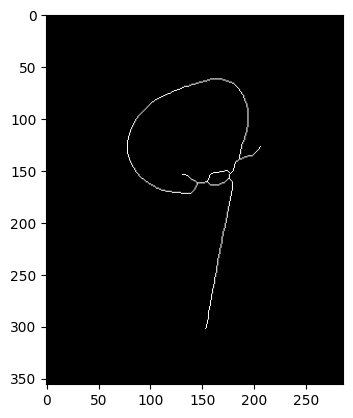

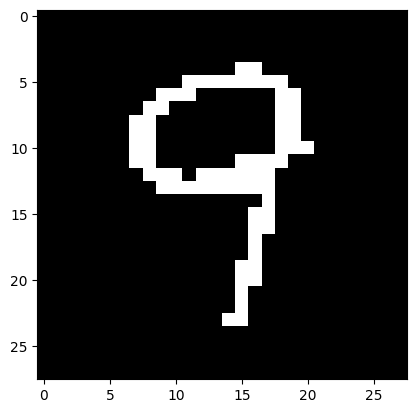

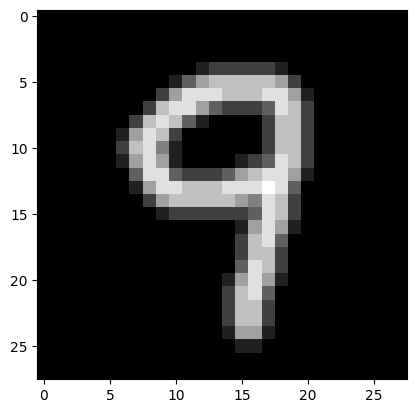

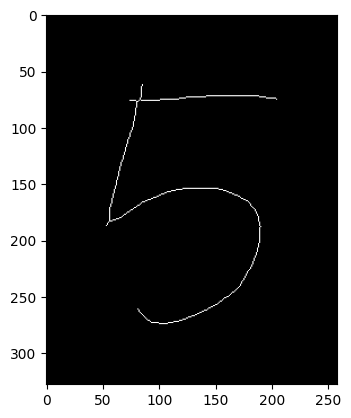

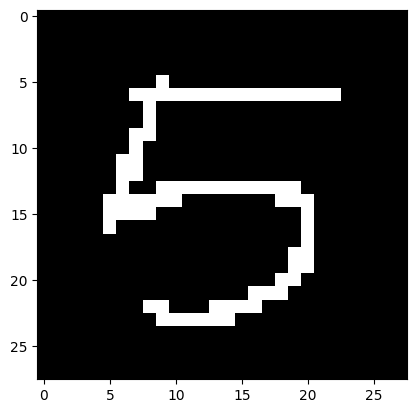

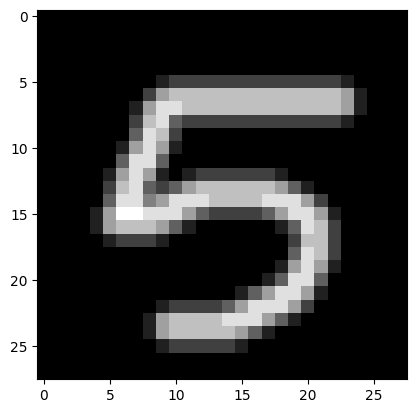

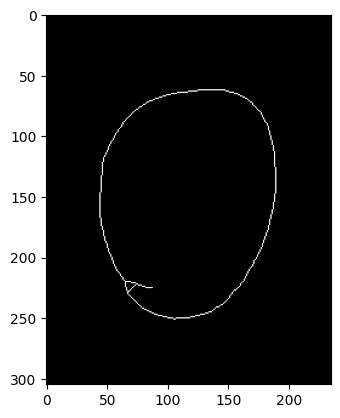

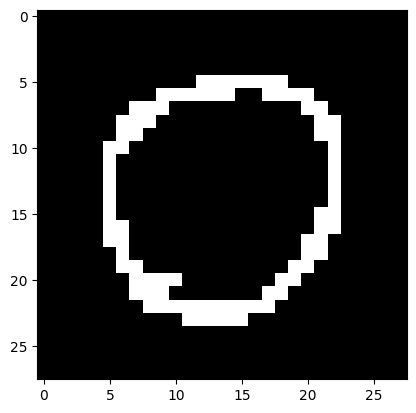

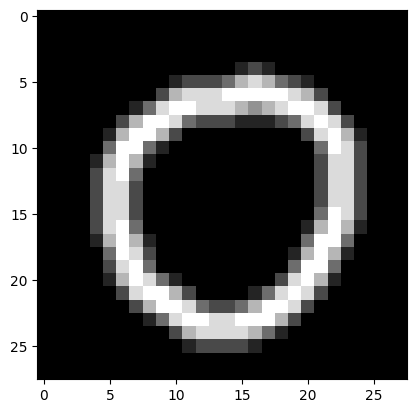

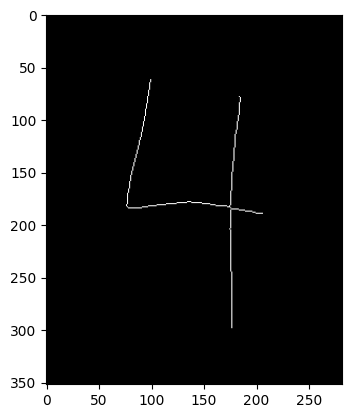

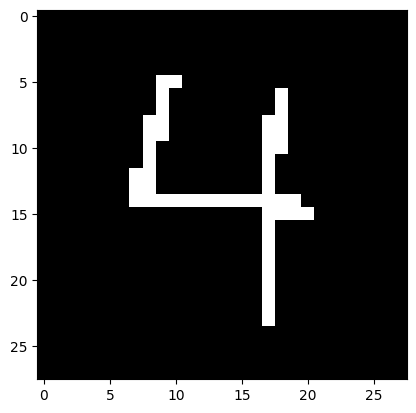

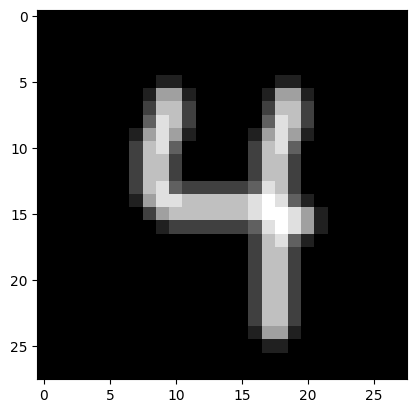

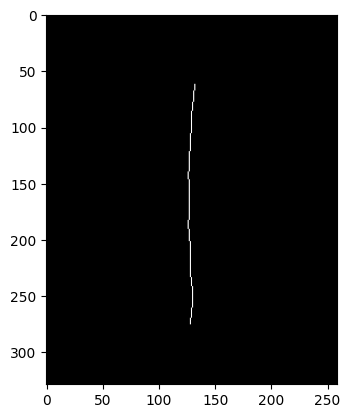

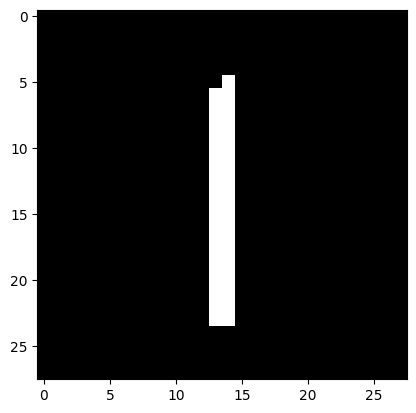

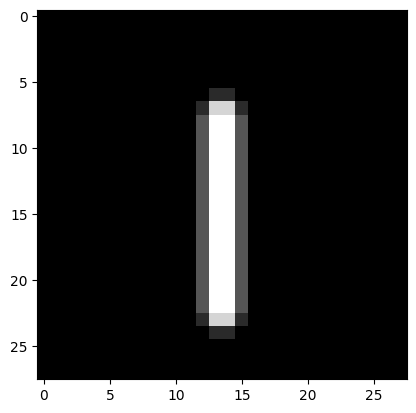

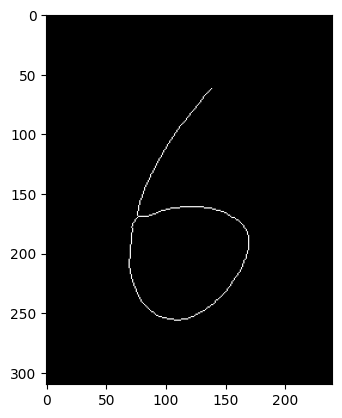

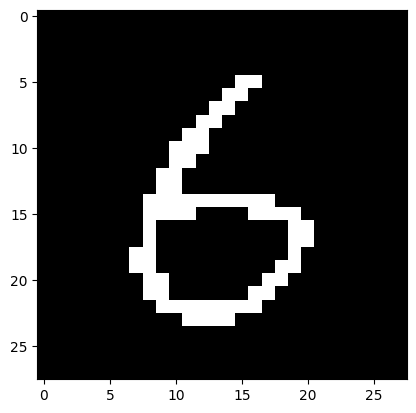

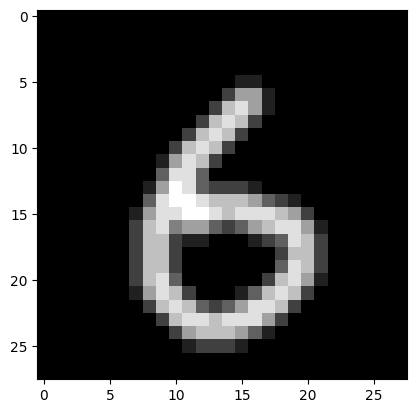

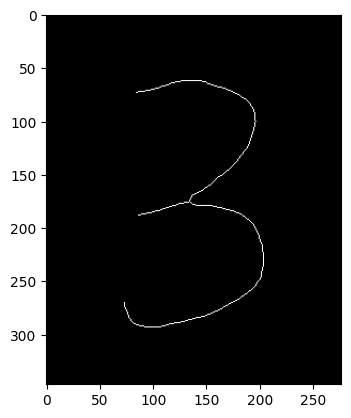

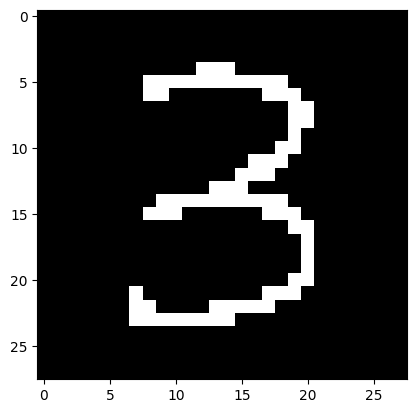

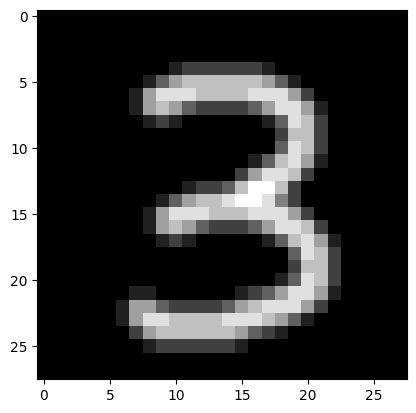

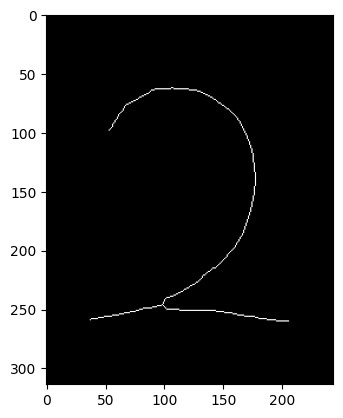

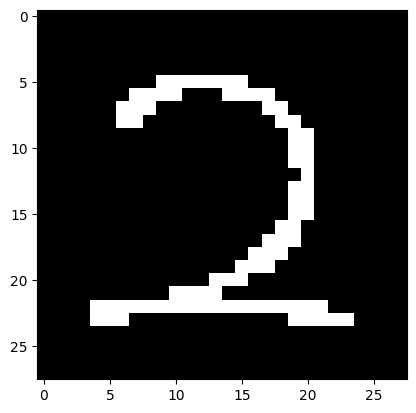

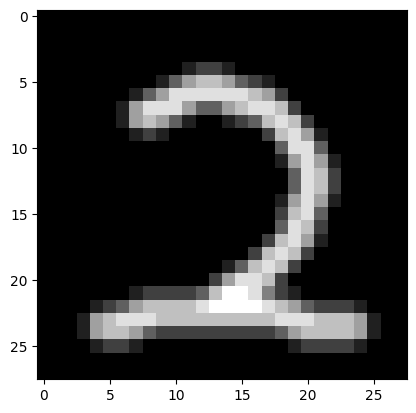

In [58]:
numbers = []
for maskSK in masks: 
    #28*28
    # cv2.imshow('mask',maskSK)
    plt.imshow(maskSK,cmap='gray')
    plt.show()
    
    #膨胀
    kernel = np.ones((8, 8), np.uint8)
    dimaskSK = cv2.dilate(maskSK, kernel) 
    
    resizedData = cv2.resize(dimaskSK,(28,28), interpolation=cv2.INTER_AREA)
    
    _,resizedData = cv2.threshold(resizedData, 0.2, 1, cv2.THRESH_BINARY)
    # cv2.imshow('resize',resizedData)
    plt.imshow(resizedData,cmap='gray')
    plt.show()
    #骨骼化
    skeleton0 = morphology.skeletonize(resizedData, method='lee')
    reskeleton = skeleton0.astype(np.uint8)*255

    # #链码
    # boundaryImg, boundaryList, chainCode = boundaryTracing(reskeleton)
    
    # #剪枝
    # reskeleton = cutoff(chainCode, boundaryList, 3)
    # cv2.imshow('ske',reskeleton)
    # pruneData = crop(reskeleton)

    # Creating kernel
    kernel = np.ones((2, 2), np.uint8)
        
    # 膨胀
    finalData = cv2.dilate(reskeleton, kernel) 

    #平滑
    kernel_size = (3, 3)
    finalData = cv2.GaussianBlur(finalData*8, kernel_size,  sigmaX=0.8)

    
    plt.imshow(finalData/np.max(finalData),cmap='gray')
    plt.show()

    # numbers.append(finalData)
    numbers.append(finalData)

In [59]:
def drawBounds(data, bounds):

    boundsImg = np.copy(data)
    for bound in bounds:
        x, y, w, h = bound[0], bound[1], bound[2], bound[3]
        x = int(x + h/2 - max(h,w)/2-5)
        y = int(y + w/2 - max(h,w)/2-5)
        w = max(h, w)+10
        h = max(h, w)+10
        if(x<0):
            x=0
        if(y<0):
            y=0
        print('frame',x,y,w,h)

        if(x+h>=480):
             h = 479 - x
        if(y+w>=640):
             w = 639 - y
        for i in range(h):
            boundsImg[x+i, y] = 0
            boundsImg[x+i, y+w] = 0
        for j in range(w):
                boundsImg[x, y+j] = 0
                boundsImg[x+h, y+j] = 0
    return boundsImg
        

def drawResult(data, bounds, results):
    resultImg = np.copy(data)
    for result in results:
        print(result)
        bound = bounds[result[0]]
        x, y, w, h = bound[0], bound[1], bound[2], bound[3]
        x = int(x + h/2 - max(h,w)/2-5)
        y = int(y + w/2 - max(h,w)/2-5)
        w = max(h, w)+10
        h = max(h, w)+10
        if(x<0):
            x=0
        if(y<0):
            y=0
        print('frame',x,y,w,h)

        if(x+h>=data.shape[0]):
             h = data.shape[0] - 1 - x
        if(y+w>=data.shape[1]):
             w = data.shape[1] - 1 - y
        for i in range(h):
            resultImg[x+i, y,:] = 0
            resultImg[x+i, y+w,:] = 0
        for j in range(w):
                resultImg[x, y+j,:] = 0
                resultImg[x+h, y+j,:] = 0

        # 定义绘制文本的属性
        font = cv2.FONT_HERSHEY_SIMPLEX
        position = (y, x)
        font_scale = 3
        color = (0, 0, 255)  # BGR颜色通道顺序，这里是红色
        thickness = 2

        # 绘制数字
        cv2.putText(resultImg, str(result[1]), position, font, font_scale, color, thickness)
    return resultImg

In [60]:
# 定义网络结构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

# 加载模型参数
model = Net()  # 创建一个新的模型实例
model.load_state_dict(torch.load('model.pth'))

# 将模型设置为评估模式
model.eval()
# 进行与训练数据相同的预处理
transform = transforms.Compose([
    # transforms.Resize((28, 28)),
    # transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

<PIL.Image.Image image mode=F size=28x28 at 0x2471EA48E80>
tensor([[-2.3028,  7.9014, -0.3068, -1.9226,  0.0476, -0.0548,  0.6302,  0.7763,
          0.6873, -1.9604]])
Predicted label: 1
<PIL.Image.Image image mode=F size=28x28 at 0x2471E951D90>
tensor([[-5.0038, -2.4765, -2.9433, -1.8214,  9.4161,  0.6727, -1.0497,  2.5326,
         -0.4187,  3.9114]])
Predicted label: 4
<PIL.Image.Image image mode=F size=28x28 at 0x2471EA48E80>
tensor([[ -0.2253,   2.6831,  13.2827,   5.5010, -10.7695,  -1.5536,  -6.9050,
           2.3040,   1.5959,  -3.6920]])
Predicted label: 2
<PIL.Image.Image image mode=F size=28x28 at 0x2471EA48BB0>
tensor([[-3.6207, -7.4039, -1.5833,  2.4716,  1.5260,  2.0198, -8.7159,  3.1907,
          2.2337, 10.1033]])
Predicted label: 9
<PIL.Image.Image image mode=F size=28x28 at 0x2471EA48E80>
tensor([[-1.5290, -6.1303,  6.6018,  2.4259, -2.8514,  1.8935, -3.3882, -4.1233,
          8.5971,  1.7399]])
Predicted label: 8
<PIL.Image.Image image mode=F size=28x28 at 0x2471

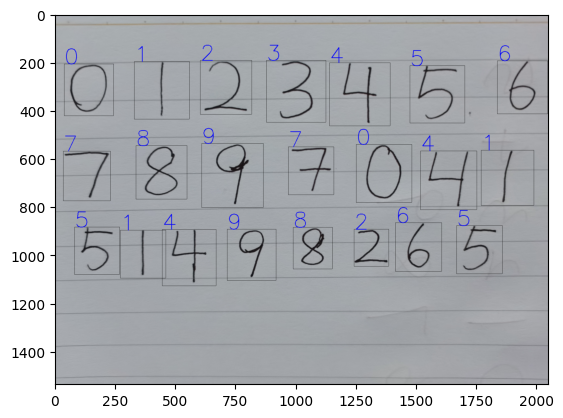

In [61]:
results = []
i = -1
for preData in numbers:
    # print(preData)
    # cv2.imshow('test',preData/np.max(preData))
    # plt.imshow(preData,cmap='gray')
    # plt.show()
    
    tensor = Image.fromarray(preData/np.max(preData))
    print(tensor)
    preprocessed_image = transform(tensor).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        outputs = model(preprocessed_image)

    print(outputs.data)
    # 获取预测结果
    _, predicted = torch.max(outputs.data, 1)
    predicted_label = predicted.item()

    print('Predicted label:', predicted_label)
    i += 1
    # if(predicted_label > 0.5):
    results.append([i, predicted_label])

resultImg = drawResult(data0, bounds, results)
plt.imshow(resultImg)

In [62]:
# cv2.imwrite('allright.jpg',resultImg)

## 预处理流程

1. 读数据 像素大小统一

2. 平滑 4x4
    去除条纹和噪声，条纹比较细，平滑对条纹的影响比较大


3. 二值化，阈值是最大值的3/5

4. 膨胀，让数字连为一体

5. 骨骼化

6. 框选骨骼，大小适中

7. 用mask取出roi， mask比数字稍大留边缘，让数字处于中下方的位置，为了和训练数据集保持统一，resize到28x28

8. 再骨骼化

9. 剪枝 链码

10. 膨胀 2x2

11. 高斯模糊，sigma=0.8 or 1

12. 输入神经网络，置信度足够高则视为数字并框选

# 1
## 标题：基于xxx的手写数字识别（？）
* 成员：xxx xxx xxx
# 2
## 图像预处理具体步骤
1. 读数据 像素大小统一
2. 频率滤波 去周期性干扰 平滑滤波 kernel = 4*4 （图片） 原因：去除条纹和噪声，条纹比较细，平滑对条纹的影响比较大 （图片对比，原图像和平滑滤波后图像）             展示平滑后滤波的图片（不太行）
# 3
3. 二值化，阈值是最大值的3/5 （图片）  A：为什么是3/5？ Q:经过试验调参发现3/5时既可以保留数字又可以有效去除细条纹
# 4
4. 膨胀，让数字连为一体 （对比图） 原因：为之后的骨骼化做铺垫，防止未连成一体的单个数字骨骼化后被分为两块
# 5
5. 对图像骨骼化处理 
6. 框选骨骼，大小适中    （骨骼化的图）（挑出来的图）2张
# 6
7. 用mask取出roi（感兴趣区region of interest）， mask比数字稍大留边缘，让数字处于中下方的位置，为了和训练数据集保持统一。resize到28x28   （类似于标准化图像的操作，把输入数据和训练数据集相匹配，例如数字较为扁小，数字不能太贴边）                  （图）
# 7
8. 再骨骼化 （去处冗余信息）
9. 剪枝 链码  （）
10. 膨胀 kernel = 2x2    (更接近真实数字的宽度)
11. 高斯模糊，sigma=0.8 or 1    (更接近真实拍摄数字和数据集中数字)

# 9
12. 将图片归一化后输入神经网络，置信度足够高则视为数字并框选(给图)    卷积层使用了什么卷积核（Relu）识别正确率98%
第一层卷积用了32个3*3卷积核，第二层卷积对每张图用了2个3*3卷积核


## 展示结果
（成功图）
## 过程中遇到的问题及解决方案
（失败图12）
